In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

In [3]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

In [4]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

def pruning_and_pca(gt, IDs, subsampling_n, size, n_iter):
    print("Investigating {} individuals".format(len(IDs)))
    gt = gt.take(IDs, axis=1)
    ac = gt.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df["callset_index"] = IDs
    pca_df_meta = pd.merge(pca_df, meta_data_samples)
    fig, ax = plt.subplots()
    sns.despine(ax=ax)
    x = np.arange(10)
    y = model1.explained_variance_ratio_ * 100
    ax.bar(x+.6, y, width=.8)
    ax.set_xticks(x+1)
    ax.set_xlim(0, 11)
    ax.set_xlabel('component')
    ax.set_ylabel('% variance explained')
    return pca_df_meta

Investigating 223 individuals
iteration 1 retaining 214724 removing 1785276 variants
iteration 2 retaining 46824 removing 167900 variants


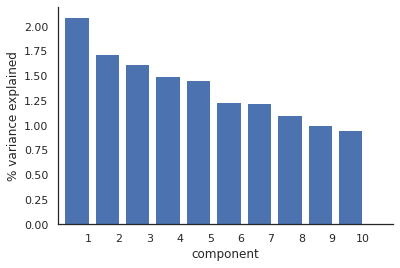

In [10]:
IDs = meta_data_samples.loc[(meta_data_samples.C_origin != "Anubis, Kenya")
                            & (meta_data_samples.C_origin != "Gelada, Captive")].callset_index.values
pca_df = pruning_and_pca(gt, IDs, 2000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


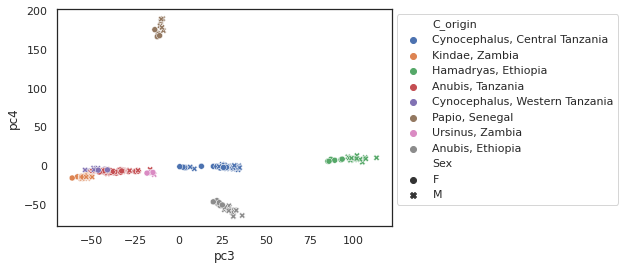

In [15]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


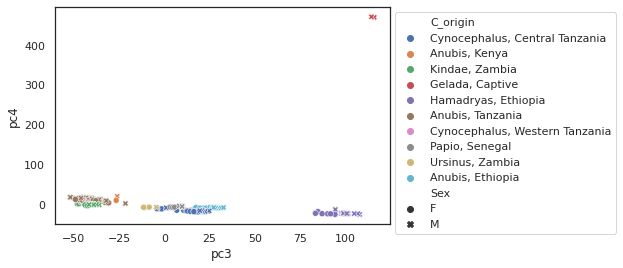

In [7]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


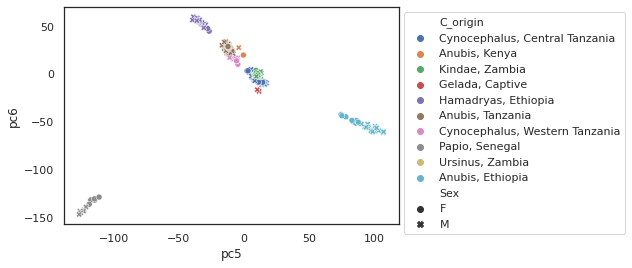

In [8]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc5", y="pc6", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


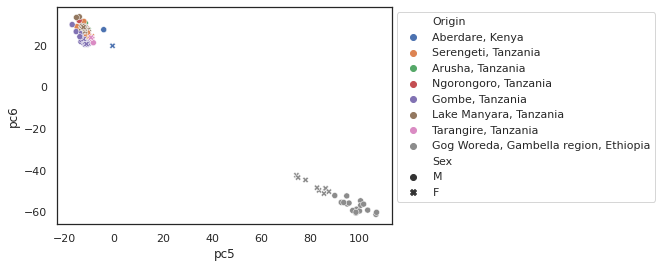

In [9]:
plt.close()
pca_df_subset = pca_df.loc[pca_df.Species=="anubis"]
scatter_sns = sns.scatterplot(data = pca_df_subset, x="pc5", y="pc6", hue="Origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)